In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Lab 3: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                               |
|-----------------------------|-------------------------------------------------------------------------------------------| 
| yr1status                   |Tree status 1 year post-fire (0 = alive, 1 = dead), defined by growing seasons
| YrFireName                  |Fire event identifier (YEAR - Fire)
| Times_burned                |Number of times the tree burned                                             
| Species                     |Symbol for species                                                    
| Genus_species               |Genus of species                                       
| DBH_cm                      |Diameter at breast height (nearest 0.1 cm) 
| HT_m                        |Pre-fire tree height (nearest 0.01 m)
| CR_pre                      |Pre-fire live crown ratio (crown length/tree height)
| CR_post                     | Post-fire live crown ratio (crown length/tree height)

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv', low_memory = False)

# Filter for variables of interest and drop NAs
trees_dat = trees_dat[["yr1status", "YrFireName", "Times_burned", "Species", "Genus_species", "DBH_cm", "HT_m", "CR_pre", "CR_post"]].dropna()

# Print number of observations
print(f"Observations:", len(trees_dat))

Observations: 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [3]:
# Recode categorical features to zero-based integer form
for col in ["YrFireName", "Species", "Genus_species"]:
     trees_dat[f"{col}_cat"] = trees_dat[col].astype("category").cat.codes
        
# Verify new columns
trees_dat.dtypes

yr1status            float64
YrFireName            object
Times_burned           int64
Species               object
Genus_species         object
DBH_cm               float64
HT_m                 float64
CR_pre               float64
CR_post              float64
YrFireName_cat          int8
Species_cat             int8
Genus_species_cat       int8
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [4]:
# Assign columns to features (X) and target variable (y)
X = trees_dat.drop(columns = ["yr1status", "YrFireName", "Species", "Genus_species"])
y = trees_dat["yr1status"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.3)

# Scale numerical features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [5]:
# Print the number of observations in training and test sets
print("Training set observations:", len(X_train))
print("Testing set observations:", len(X_test))

Training set observations: 10952
Testing set observations: 25557


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [6]:
# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train_scaled)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print training accuracy
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9442


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [7]:
# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.9425
Confusion Matrix:
[[23004   422]
 [ 1048  1083]]


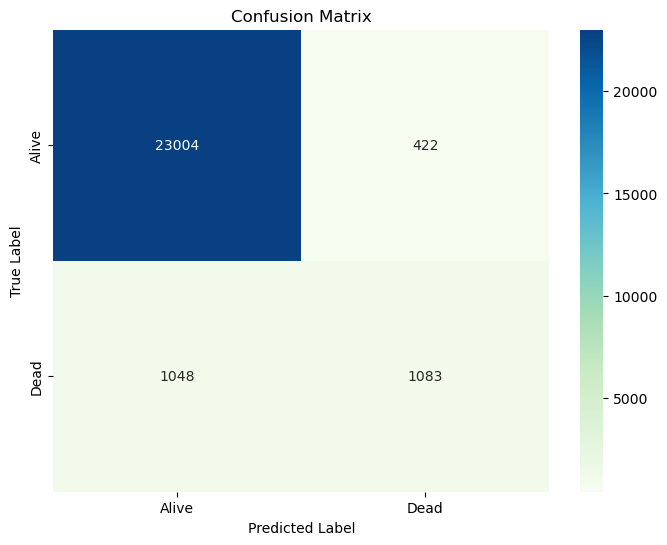

In [8]:
# Plot confusion matrix heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "GnBu",
            xticklabels = ["Alive", "Dead"],
            yticklabels = ["Alive", "Dead"])
    
# Add a title
plt.title("Confusion Matrix")
    
# Add axis labels
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
    
# Display plot
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model achieved 94% accuracy on the unseen data, meaning it correctly classified tree survival in most cases. However, its performance differs between trees that survived and those that died. The model correctly identifies dead trees only about half the time, meaning it struggles to predict tree mortality (sensitivity ~ 50%), but is highly accurate at identifying trees that survived (specifity ~ 98%). This suggests a class imbalance in this dataset where the model is biased toward predicting tree survival.

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

If we built a model that always predicts the majority class, in this case, alive trees, its accuracy would likely be high, similar to the logistic regression model. However, this would be misleading. The model would have 0% sensitivity, as it would never correctly predict dead trees, but it would achieve 100% specificity by correctly identifying all the alive trees. This highlights the importance of using ROC and AUC analysis to better evaluate model performance, as accuracy alone does not provide a full picture, especially in cases of class imbalance.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [9]:
# Train a Dummy Classifier using the most frequent class strategy
dummy = DummyClassifier(strategy = "most_frequent")
dummy.fit(X_train_scaled, y_train)

# Make predictions on the training data
dummy_train_pred = dummy.predict(X_train_scaled)

# Calculate accuracy on the training data
dummy_train_accuracy = accuracy_score(y_train, dummy_train_pred)

# Generate confusion matrix
dummy_train_cm = confusion_matrix(y_train, dummy_train_pred)

# Print the dummy classifier's training accuracy and confusion matrix
print(f"Dummy Training Accuracy: {dummy_train_accuracy:.4f}")
print("\nDummy Training Confusion Matrix:")
print(dummy_train_cm)

Dummy Training Accuracy: 0.9175

Dummy Training Confusion Matrix:
[[10048     0]
 [  904     0]]


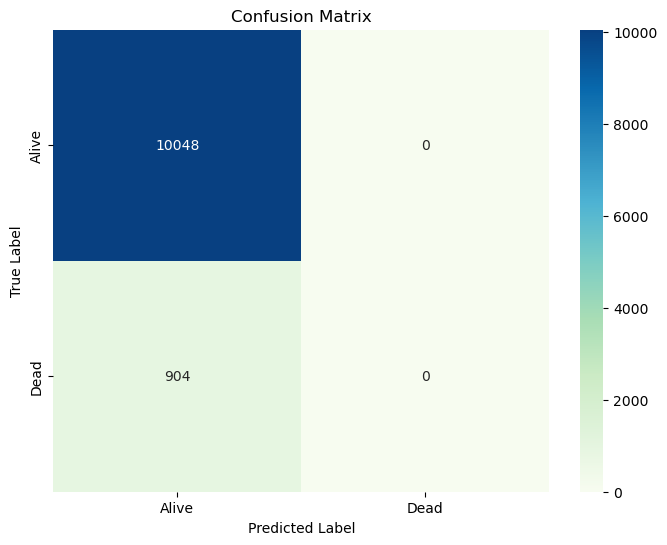

In [10]:
# Plot confusion matrix heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(dummy_train_cm, annot = True, fmt = "d", cmap = "GnBu", 
            xticklabels = ["Alive", "Dead"],
            yticklabels = ["Alive", "Dead"])
    
# Add a title
plt.title("Confusion Matrix")
    
# Add axis labels
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
    
# Display plot
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [11]:
# Logistic classifier AUC
model_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    
# Print AUC    
print(f"Logistic AUC: {model_auc:.4f}")

Logistic AUC: 0.9271


In [12]:
# Dummy classifier AUC
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test_scaled)[:, 1])

# Print AUC
print(f"Dummy AUC: {dummy_auc:.4f}")

Dummy AUC: 0.5000


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

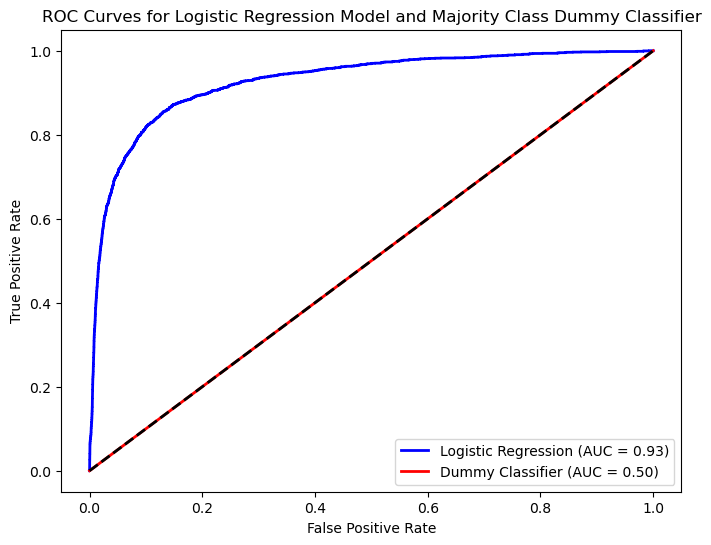

In [13]:
# Get ROC curve data for both models
model_fpr, model_tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy.predict_proba(X_test_scaled)[:, 1])
    
# Plot ROC curves
plt.figure(figsize = (8, 6))
plt.plot(model_fpr, model_tpr, color = "blue", lw = 2, label = f"Logistic Regression (AUC = {model_auc:.2f})")
plt.plot(dummy_fpr, dummy_tpr, color = "red", lw = 2, label = f"Dummy Classifier (AUC = {dummy_auc:.2f})")
    
# Plot the diagonal line
plt.plot([0, 1], [0, 1], color = "black", lw = 2, linestyle = "dashed")
    
# Add a title
plt.title("ROC Curves for Logistic Regression Model and Majority Class Dummy Classifier")

# Add axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Add a legend
plt.legend(loc = "lower right")
    
# Show the plot
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The logistic regression model clearly demonstrates strong performance with a high AUC of 0.93, indicating its ability to effectively distinguish between the two outcomes (dead vs. alive trees). In contrast, the majority class dummy classifier has an AUC of 0.5, which reflects performance no better than random guessing, as evidenced by the dashed line on the plot. This highlights why evaluating classifiers based solely on accuracy can be misleading, especially in imbalanced datasets. Incorporating ROC and AUC is crucial to more accurately assess a model's effectiveness.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [14]:
# Get the coefficients from the logistic regression model
coefficients = model.coef_[0]
feature_names = X_train.columns

# Create a dataframe for easy interpretation
importance_df = pd.DataFrame({"Feature": feature_names,
                              "Coefficient": coefficients}).sort_values(by = "Coefficient")

# Print the sorted feature importance
print(importance_df)

             Feature  Coefficient
4            CR_post    -2.447684
2               HT_m    -1.066283
5     YrFireName_cat    -0.711743
7  Genus_species_cat    -0.047303
0       Times_burned     0.000000
3             CR_pre     0.100305
1             DBH_cm     0.337031
6        Species_cat     0.525445


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

Based on the logistic regression model, the most important features appear to be the post-fire crown ratio (CR_post) and the pre-fire tree height (HT_m). These features seem to have the most significant impact on predicting tree survival one year post-fire. The post-fire crown ratio reflects the tree's ability to regenerate and recover after the fire, while the pre-fire height could indicate the tree's overall resilience and ability to withstand damage from fire. Understanding which characteristics predict tree survival can help shape more informed forest management plans. For example, prioritizing trees with higher pre-fire height and better crown ratios could improve fire resilience strategies.